<a href="https://colab.research.google.com/github/Abhinavjoshi7891/Google-Colab-Abhinav/blob/main/kagle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TalkingData: Fraudulent Click Prediction

## In this notebook, we will apply various boosting algorithms to solve an interesting classification problem from the domain of 'digital fraud'.
### The analysis is divided into the following sections:

- Understanding the business problem
- Understanding and exploring the data
- Feature engineering: Creating new features
- Model building and evaluation: AdaBoost
- Modelling building and evaluation: Gradient Boosting
- Modelling building and evaluation: XGBoost

# **Understanding the Business Problem**
TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released the problem on Kaggle here..

# **Understanding and Exploring the Data**
The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

- ip: ip address of click.
- app: app id for marketing.
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, - huawei mate 7, etc.)
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded
Let's try finding some useful trends in the data.

In [3]:
## importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Reading the Data
The code below reads the train_sample.csv file if you set testing = True, else reads the full train.csv file. You can read the sample while tuning the model etc., and then run the model on the full data once done.

## Important Note: Save memory when the data is huge
Since the training data is quite huge, the program will be quite slow if you don't consciously follow some best practices to save memory. This notebook demonstrates some of those practices.

In [4]:
## reading the training data
## # specify column dtypes to save memory (by default pandas reads some columns as floats)
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }
## read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']


In [5]:
# read training data
train_sample = pd.read_csv(train_path, skiprows=skiprows, nrows=nrows, dtype=dtypes, usecols=colnames)

In [6]:
## lenght of the training data
len(train_sample.index)

100000

In [7]:
## Displays memory consumed by each column ---
print(train_sample.memory_usage())

Index               128
ip               200000
app              200000
device           200000
os               200000
channel          200000
click_time       800000
is_attributed    100000
dtype: int64


In [8]:
## space used by training data
space = train_sample.memory_usage().sum()/1024**2
print(f'Training dataset uses {space} MB data',space)

Training dataset uses 1.812103271484375 MB data 1.812103271484375


In [9]:
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0
2,35888,12,1,19,212,2017-11-07 18:05:24,0
3,29048,13,1,13,477,2017-11-07 04:58:08,0
4,2877,12,1,1,178,2017-11-09 09:00:09,0


# Exploring the Data - Univariate Analysis
- Let's now understand and explore the data. Let's start with understanding the size and data types of the train_sample data.

In [10]:
## checking null values, dtypes 
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ip             100000 non-null  uint16
 1   app            100000 non-null  uint16
 2   device         100000 non-null  uint16
 3   os             100000 non-null  uint16
 4   channel        100000 non-null  uint16
 5   click_time     100000 non-null  object
 6   is_attributed  100000 non-null  uint8 
dtypes: object(1), uint16(5), uint8(1)
memory usage: 1.8+ MB


- NO null values, click_time will have to be fixed later

### Basic exploratory analysis

In [11]:
## let's check unique values
train_sample.nunique()

ip               28470
app                161
device             100
os                 130
channel            161
click_time       80350
is_attributed        2
dtype: int64

### let's see the distribution of different categories

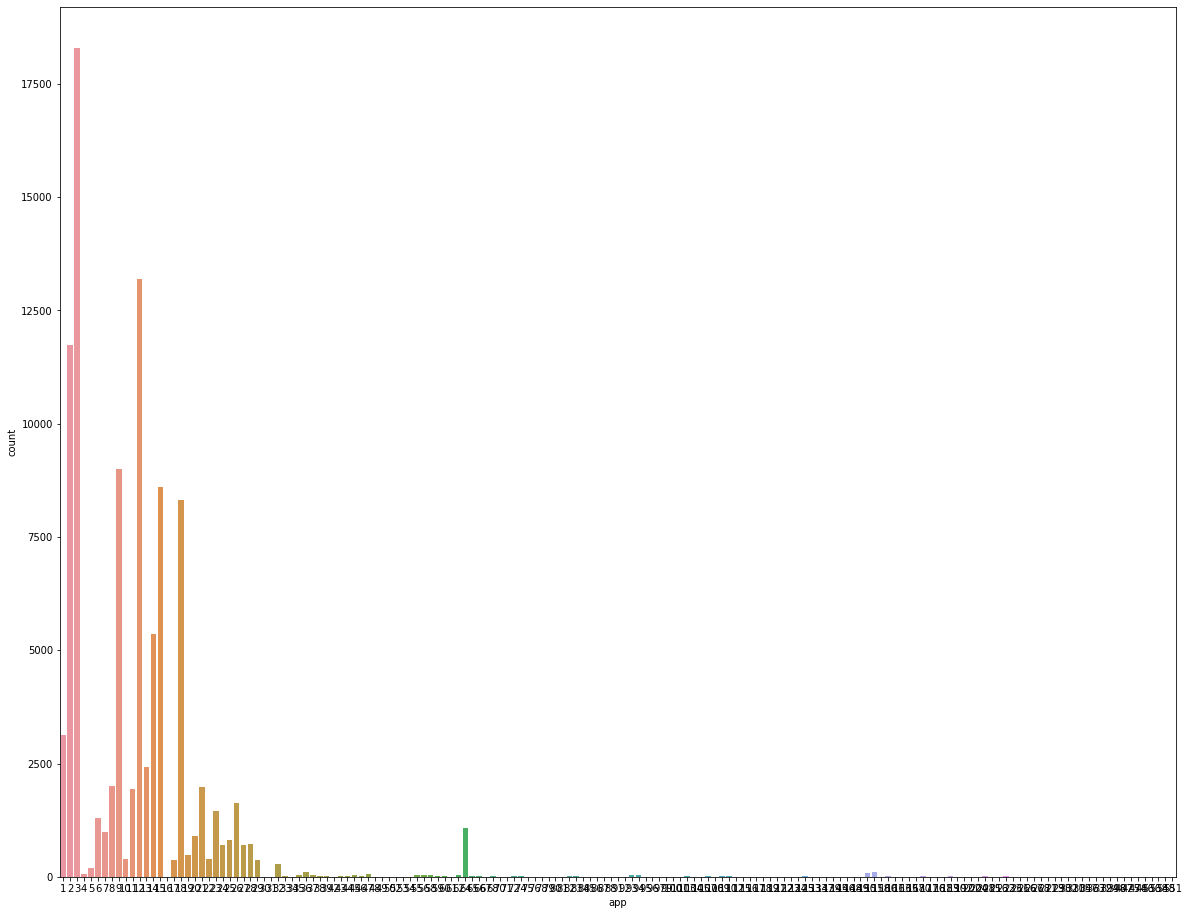

In [12]:
## countplot for app
plt.figure(figsize=(20,16))
sns.countplot(data=train_sample,x='app')
plt.show()

- Clearly some apps show very high clicks.
- This indicates class imbalance

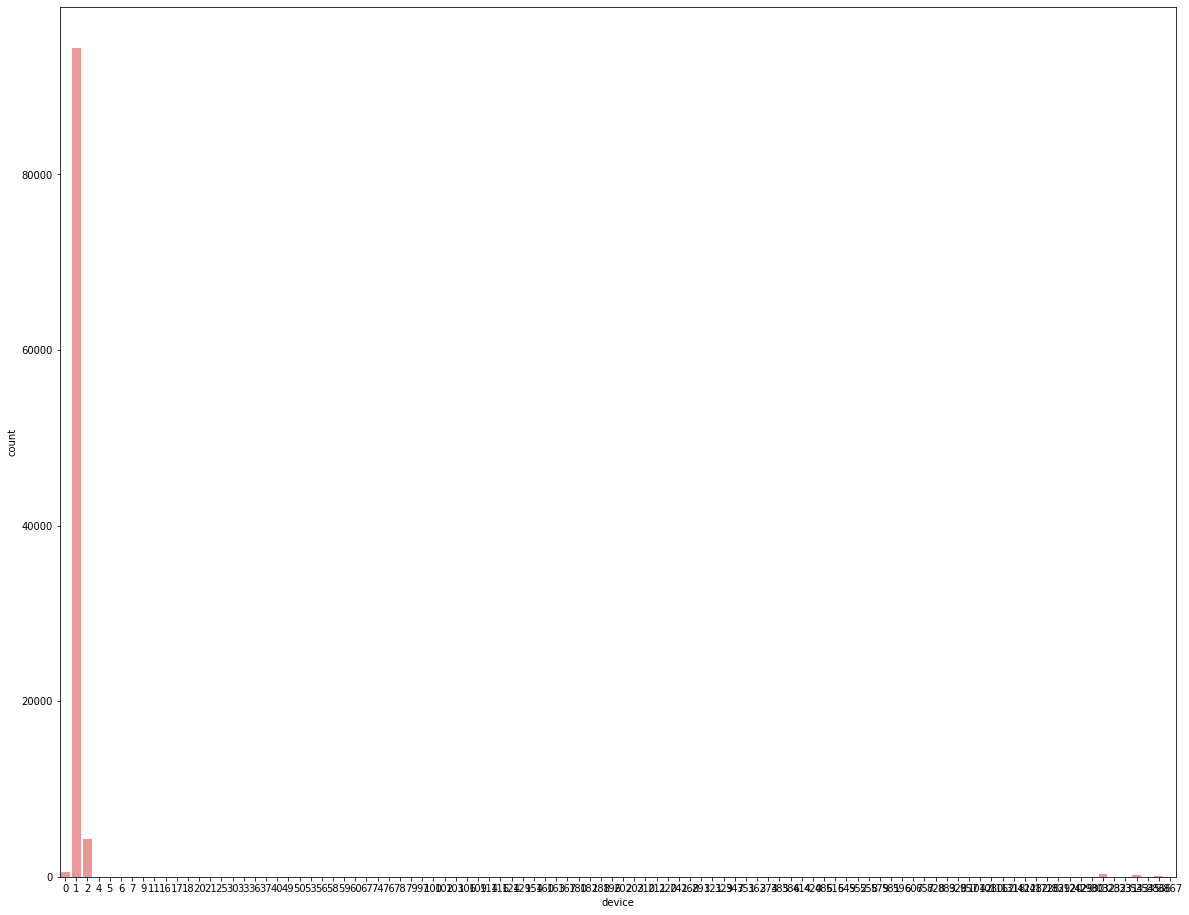

In [13]:
## countplot for device 
plt.figure(figsize=(20,16))
sns.countplot(data=train_sample,x='device')
plt.show()

- High class imbalance in device as well
- Expected as some devices are more popular 

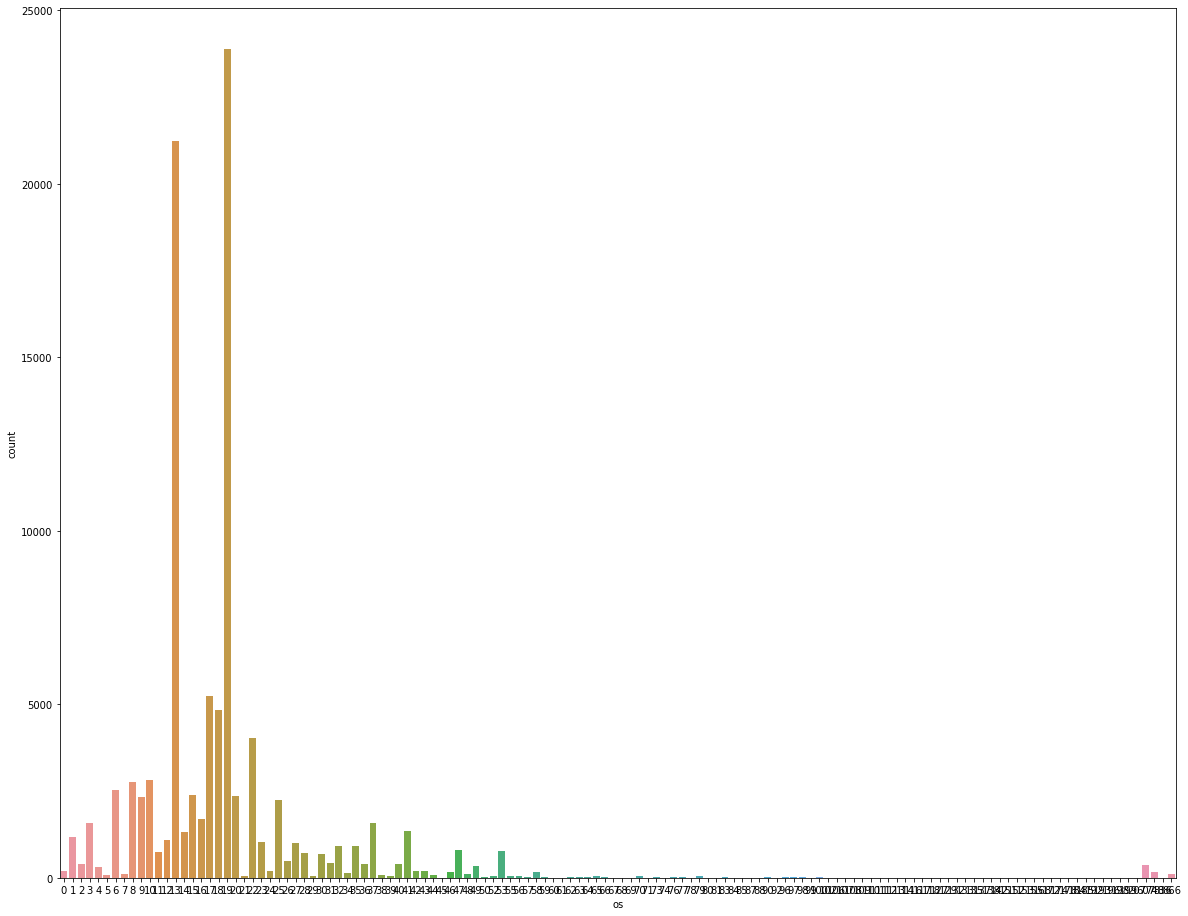

In [14]:
## countplot for os 
plt.figure(figsize=(20,16))
sns.countplot(data=train_sample,x='os')
plt.show()

- Some OS are more popular than others

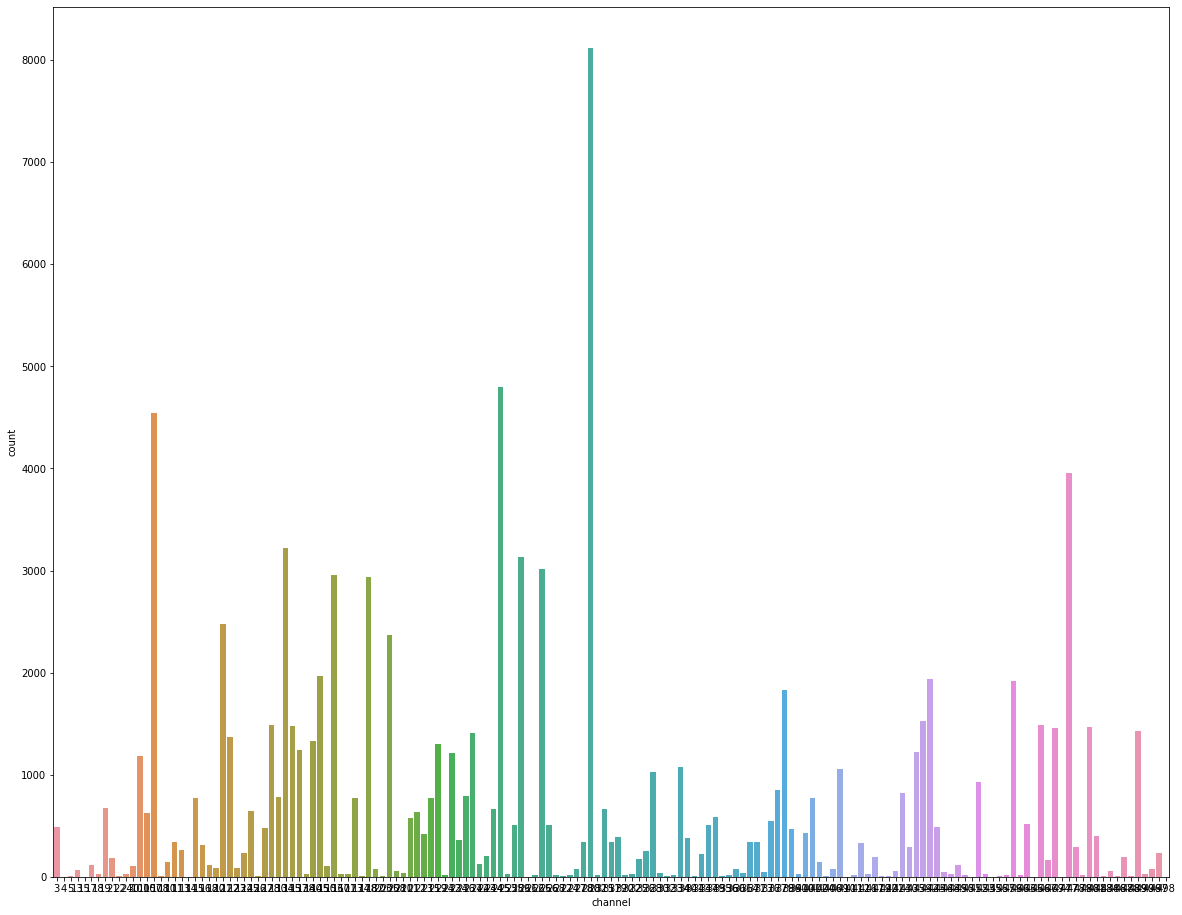

In [15]:
## countplot for channel
plt.figure(figsize=(20,16))
sns.countplot(data=train_sample,x='channel')
plt.show()

- Channels have more or less equitable distribution

# Let's now look at the distribution of the target variable 'is_attributed'.

In [16]:
# # target variable distribution
train_sample['is_attributed'].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

In [17]:
227/100000*100

0.22699999999999998

- Only about 0.2% of clicks are 'fraudulent', which is expected in a fraud detection problem. Such high class imbalance is probably going to be the toughest challenge of this problem.

# Exploring the Data - Segmented Univariate Analysis
- Let's now look at how the target variable varies with the various predictors.

### Plotting average of target variable(download rate) wrt 'app'

In [18]:
## using groupby to make a table of the two
app_target = train_sample.groupby('app').is_attributed.agg(['mean','count'])
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


-This is clearly non-readable, so let's first get rid of all the apps that are very rare (say which comprise of less than 20% clicks) and plot the rest.
- Let's create another variable called frequent apps which will contain the top 80% quantile of apps.
- Approach:
   - 1. Reset index to 'count'
   - 2. Select those which satisfy the condition of counts being greater than 80% quantile.

In [19]:
## Creating frequent_apps
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')

In [20]:
## selecting top 80% quantile
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(.80)]

In [21]:
## merging with the main dataset
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()

,app,count,ip,device,os,channel,click_time,is_attributed
0,1,3135,17059,1,17,135,2017-11-09 01:17:58,0
1,1,3135,52432,1,13,115,2017-11-07 17:22:52,0
2,1,3135,23706,1,27,124,2017-11-07 09:37:21,0
3,1,3135,58458,1,19,101,2017-11-09 14:27:57,0
4,1,3135,34067,1,15,134,2017-11-07 15:06:06,0


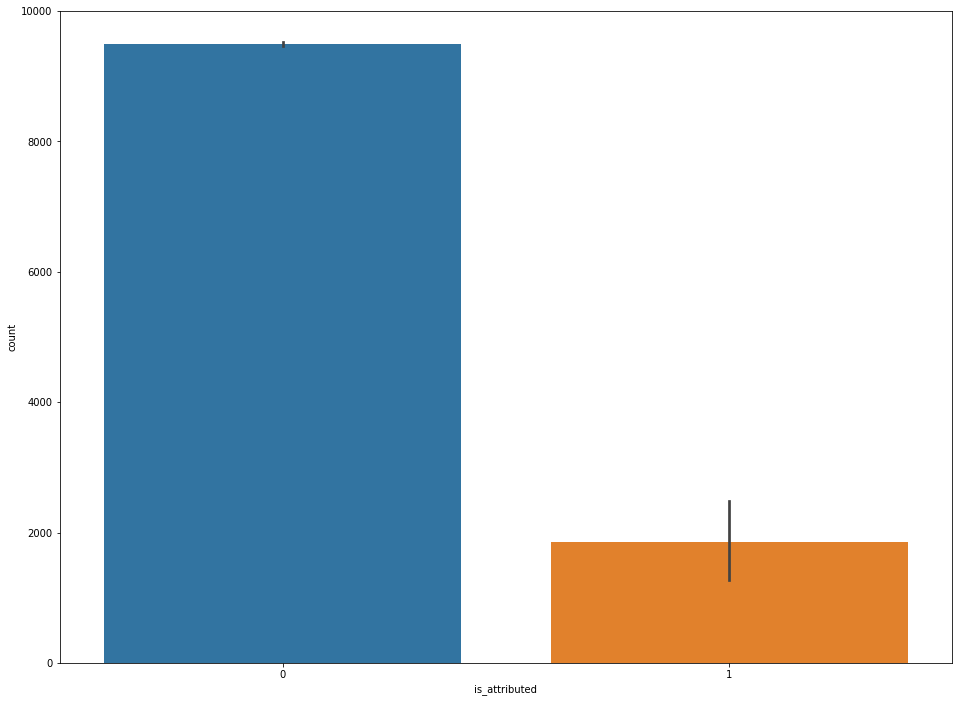

In [24]:
## plotting
plt.figure(figsize=(16,12))
sns.barplot(data=frequent_apps,y='count',x='is_attributed')
plt.show()

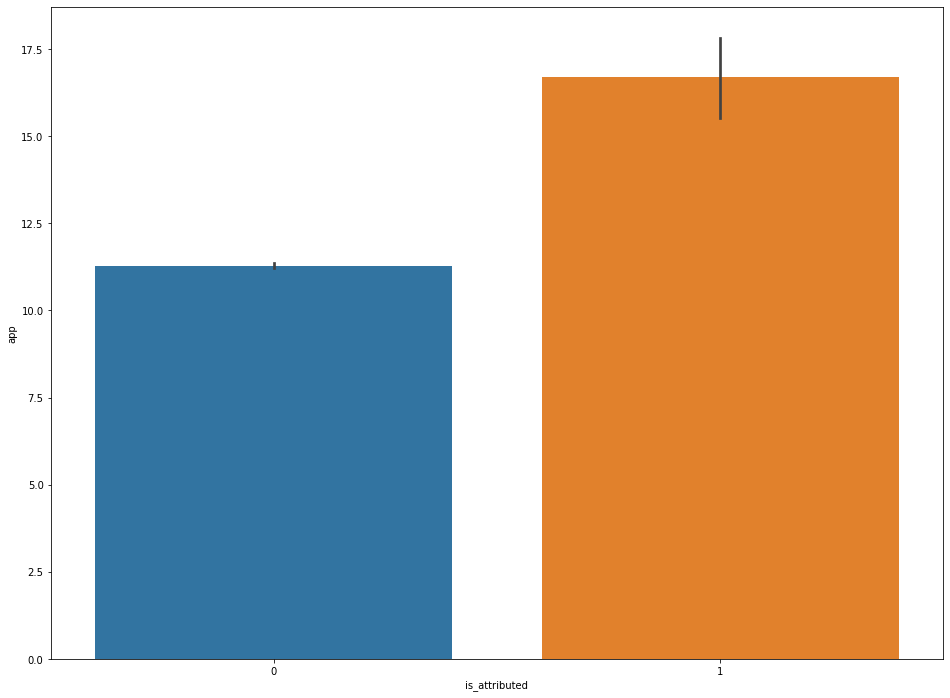

In [27]:
plt.figure(figsize=(16,12))
sns.barplot(data=frequent_apps,y='app',x='is_attributed')
plt.show()

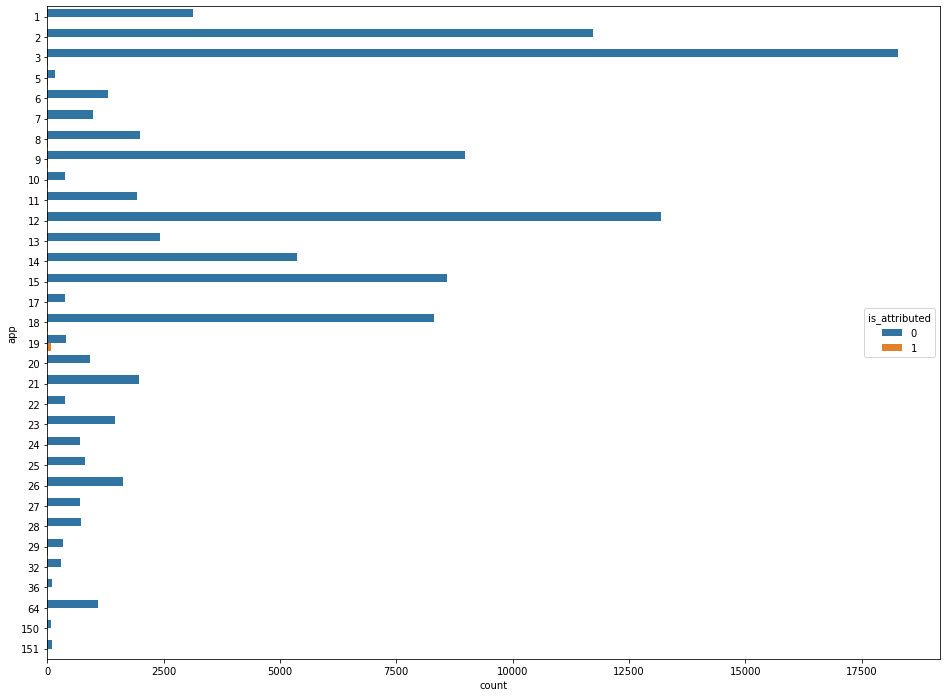

In [31]:
plt.figure(figsize=(16,12))
sns.countplot(data=frequent_apps,y='app',hue='is_attributed')
plt.show()

- We can do lots of other interesting ananlysis with the existing features. For now, let's create some new features which will probably improve the model.

# **Feature Engineering**
- Let's now derive some new features from the existing ones. There are a number of features one can extract from click_time itself, and by grouping combinations of IP with other features.


## **Datetime Based Features**
- We will be creating a function timeFeatures which takes in a dataframe, adds date/time based columns to it, and returns the modified dataframe.

In [34]:
def timeFeatures(df):
  df['datetime'] = pd.to_datetime(df['click_time']) ## this will convert to click_time variable to datetime object
  ## now we will use the datetime object to derive multiple features like day_of_week,day_of_year,month,hour
  ## creating column day_of_week
  df['day_of_week'] = df['datetime'].dt.day_of_week
  ## creating column day_of_year
  df['day_of_year'] = df['datetime'].dt.day_of_year
  ## creatig column month
  df['month'] = df['datetime'].dt.month
  ## creating column hour
  df['hour'] = df['datetime'].dt.hour
  return df


